In [1]:
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt
import numpy as np
import tensorflow_datasets as tfds

/Users/szymon.rucinski/Desktop/AiRoll/airoll/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Datasets

In [2]:
builder = tfds.ImageFolder('/Users/szymon.rucinski/Desktop/AiRoll/data/')

2022-10-05 17:56:01.063992: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [3]:
ds = builder.as_dataset(split='train', shuffle_files=True)
# tfds.show_examples(ds, builder.info)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-05 17:56:01.442321: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-05 17:56:01.442665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Display dataset

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True,validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=r"../data/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="training"
)

validation_generator = datagen.flow_from_directory(
    directory=r"../data/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="validation"
)

Found 576 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [5]:
from itertools import count
a = train_generator.classes.flatten().tolist()
dist_dict = {}
for label,number in train_generator.class_indices.items():
    dist_dict[label] = a.count(number)
dist_dict

{'closeUp': 76,
 'detail': 42,
 'extremeLongShot': 78,
 'fullShot': 52,
 'longShot': 77,
 'mediumCloseUp': 112,
 'mediumShot': 139}

In [6]:
train_generator.class_indices.items()

dict_items([('closeUp', 0), ('detail', 1), ('extremeLongShot', 2), ('fullShot', 3), ('longShot', 4), ('mediumCloseUp', 5), ('mediumShot', 6)])

(32, 224, 224, 3)


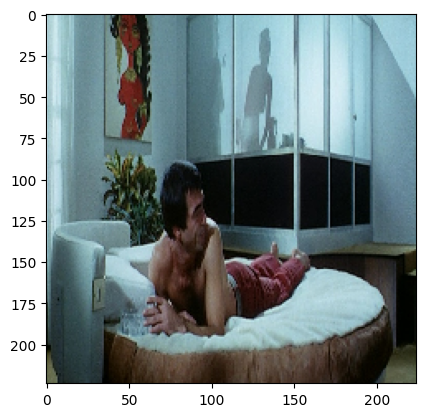

(32, 224, 224, 3)


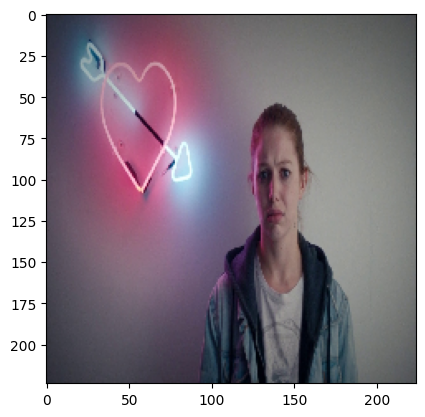

(32, 224, 224, 3)


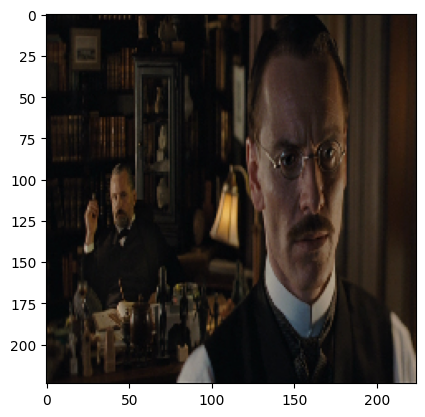

(32, 224, 224, 3)


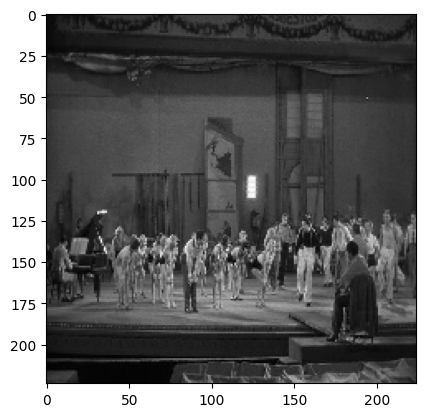

(32, 224, 224, 3)


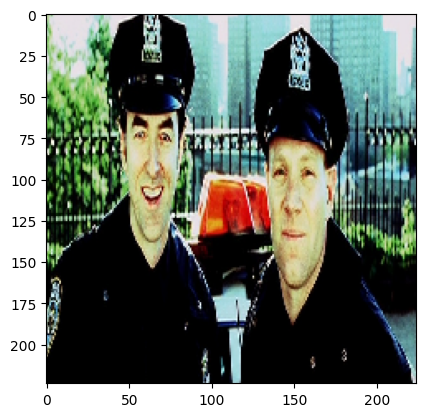

In [7]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [8]:
train_generator.class_indices

{'closeUp': 0,
 'detail': 1,
 'extremeLongShot': 2,
 'fullShot': 3,
 'longShot': 4,
 'mediumCloseUp': 5,
 'mediumShot': 6}

# Model Compilation

In [9]:
resnet50 = ResNet50(include_top=False)
resnet50.trainable = False

In [10]:
# To ensure that TensorFlow does not retrain the mobile_net_layers, use this code:


In [11]:
# # Build the neural network and add custom layers.
# neural_net = tf.keras.Sequential([
#   resnet50,
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(7,activation='softmax')
# ])

In [12]:
resnet_model = tf.keras.Sequential()
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling="avg",
    classes=7)
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
resnet_model.add(tf.keras.layers.Dropout(rate=0.3))
resnet_model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 1,052,679
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
#Compile the deep neural network using the following code
learning_rate = 0.1
epochs=100
resnet_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[
            tf.keras.metrics.Accuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ],
)

In [15]:
model_fit = resnet_model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
        ],)      

Epoch 1/100


2022-10-05 17:56:06.347440: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-05 17:56:07.818285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 2.1215 - precision: 0.1875 - recall: 0.0156

2022-10-05 17:56:12.010214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 7s 302ms/step - loss: 2.1215 - precision: 0.1875 - recall: 0.0156 - val_loss: 1.8747 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
18/18 [==============================] - 4s 227ms/step - loss: 1.9402 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8197 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
18/18 [==============================] - 4s 213ms/step - loss: 1.9108 - precision: 0.2727 - recall: 0.0052 - val_loss: 1.8516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 4s 223ms/step - loss: 1.8610 - precision: 1.0000 - recall: 0.0017 - val_loss: 1.8095 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
18/18 [==============================] - 4s 223ms/step - loss: 1.8385 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.7958 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/100
18/18 [======================

In [ ]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

In [ ]:
from tensorflow.keras.models import Model

conv_output = neural_net.get_layer('resnet50').get_layer("conv5_block3_out").output
pred_output = neural_net.get_layer("dense").output
input_layer = neural_net.get_layer('resnet50').get_layer('input_1').input


explained_model = tf.keras.Model(input_layer, outputs=[conv_output, pred_output])

In [ ]:
pred_output = neural_net.get_layer("dense_9").output

In [ ]:
neural_net.get_layer('resnet50').get_layer("input_9").input